## PrizePicks Betting Line Analyzer

This notebook analyzes NBA player statistics to evaluate PrizePicks betting lines.

**Features:**
- Load player statistics and position data
- Analyze hit rates for over/under lines
- Factor in opponent matchups by position
- Home/Away performance splits
- Recent form analysis (last N games)
- Generate recommendations with confidence levels

In [17]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import kagglehub
import os
import ast
from datetime import datetime, timedelta

sns.set(font_scale=1.5, style="white")
plt.rcParams['figure.figsize'] = [12, 6]

In [18]:
# Load position data from first notebook
import os

# Get the directory where this notebook is located
notebook_dir = os.path.dirname(os.path.abspath("__file__"))
csv_path = os.path.join(notebook_dir, "position_data.csv")

# If that doesn't work, try absolute path
if not os.path.exists(csv_path):
    csv_path = r"C:\Users\elan0\Documents\GitHub\Young-Bull-Picks\position_data.csv"

# Use latin-1 encoding to handle special characters in player names
players = pd.read_csv(csv_path, encoding='latin-1')

# Parse the Position column from string to list
def parse_position(pos_str):
    if pd.isna(pos_str) or pos_str == '[]':
        return []
    try:
        return ast.literal_eval(pos_str)
    except:
        return []

players['Position'] = players['Position'].apply(parse_position)
print(f"Loaded {len(players)} players with position data")
players.head(10)

Loaded 547 players with position data


,Name,Position
0,Melvin Ajinca,[]
1,Adem Bona,[C]
2,Matas Buzelis,"[SF, PF]"
3,Carlton Carrington,"[PG, SG]"
4,Devin Carter,[]
5,Stephon Castle,"[PG, SG]"
6,Ulrich Chomche,[C]
7,Cam Christie,"[PG, SG]"
8,Donovan Clingan,[C]
9,Isaiah Collier,"[PG, SG]"


In [19]:
# Load current season data from Kaggle
path = kagglehub.dataset_download("eduardopalmieri/nba-player-stats-season-2425")
csv_file = os.path.join(path, "database_24_25.csv")
season_data = pd.read_csv(csv_file)

# Convert date column
season_data['Data'] = pd.to_datetime(season_data['Data'])

# Create stat mapping for PrizePicks categories
STAT_COLUMNS = {
    'PTS': 'Points',
    'TRB': 'Rebounds', 
    'AST': 'Assists',
    'STL': 'Steals',
    'BLK': 'Blocks',
    '3P': '3-Pointers Made',
    'TOV': 'Turnovers',
    'PF': 'Personal Fouls'
}

# Create combined stats
season_data['PTS+REB'] = season_data['PTS'] + season_data['TRB']
season_data['PTS+AST'] = season_data['PTS'] + season_data['AST']
season_data['PTS+REB+AST'] = season_data['PTS'] + season_data['TRB'] + season_data['AST']
season_data['REB+AST'] = season_data['TRB'] + season_data['AST']
season_data['STL+BLK'] = season_data['STL'] + season_data['BLK']

print(f"Loaded {len(season_data)} game records for current season")
print(f"Date range: {season_data['Data'].min()} to {season_data['Data'].max()}")
print(f"Unique players: {season_data['Player'].nunique()}")

Loaded 16512 game records for current season
Date range: 2024-10-22 00:00:00 to 2025-02-07 00:00:00
Unique players: 562


## Core Analysis Functions

In [20]:
def get_player_stats(player_name, stat_col, last_n_games=None):
    """Get a player's stats for a specific category."""
    player_data = season_data[season_data['Player'] == player_name].copy()
    player_data = player_data.sort_values('Data', ascending=False)
    
    if last_n_games:
        player_data = player_data.head(last_n_games)
    
    return player_data[['Data', 'Opp', 'Res', stat_col, 'MP']].reset_index(drop=True)


def analyze_line(player_name, stat_col, line, last_n_games=None):
    """
    Analyze a betting line for a player.
    Returns hit rate, average, and other metrics.
    """
    player_data = season_data[season_data['Player'] == player_name].copy()
    player_data = player_data.sort_values('Data', ascending=False)
    
    if last_n_games:
        player_data = player_data.head(last_n_games)
    
    if len(player_data) == 0:
        return None
    
    stats = player_data[stat_col]
    
    over_hits = (stats > line).sum()
    under_hits = (stats < line).sum()
    pushes = (stats == line).sum()
    total_games = len(stats)
    
    return {
        'player': player_name,
        'stat': stat_col,
        'line': line,
        'games_analyzed': total_games,
        'average': stats.mean(),
        'median': stats.median(),
        'std_dev': stats.std(),
        'min': stats.min(),
        'max': stats.max(),
        'over_hits': over_hits,
        'under_hits': under_hits,
        'pushes': pushes,
        'over_rate': over_hits / total_games * 100,
        'under_rate': under_hits / total_games * 100,
        'last_5_avg': player_data.head(5)[stat_col].mean() if len(player_data) >= 5 else stats.mean(),
        'last_10_avg': player_data.head(10)[stat_col].mean() if len(player_data) >= 10 else stats.mean(),
        'avg_minutes': player_data['MP'].mean(),
    }


def get_vs_opponent(player_name, stat_col, opponent):
    """Get player's stats against a specific opponent."""
    player_data = season_data[
        (season_data['Player'] == player_name) & 
        (season_data['Opp'] == opponent)
    ]
    
    if len(player_data) == 0:
        return None
    
    return {
        'games': len(player_data),
        'average': player_data[stat_col].mean(),
        'min': player_data[stat_col].min(),
        'max': player_data[stat_col].max(),
        'results': player_data[['Data', stat_col, 'Res']].to_dict('records')
    }


def get_player_positions(player_name):
    """Get positions for a player from our position data."""
    match = players[players['Name'] == player_name]
    if len(match) > 0:
        return match.iloc[0]['Position']
    return []


def analyze_position_matchup(player_name, stat_col, opponent):
    """
    Analyze how the opponent defends against the player's position.
    """
    player_positions = get_player_positions(player_name)
    
    if not player_positions:
        return None
    
    # Get all players with same positions
    same_position_players = players[
        players['Position'].apply(lambda x: any(pos in x for pos in player_positions))
    ]['Name'].tolist()
    
    # Get stats of those players against the opponent
    matchup_data = season_data[
        (season_data['Player'].isin(same_position_players)) &
        (season_data['Opp'] == opponent)
    ]
    
    if len(matchup_data) == 0:
        return None
    
    return {
        'opponent': opponent,
        'positions': player_positions,
        'games_sampled': len(matchup_data),
        'avg_stat': matchup_data[stat_col].mean(),
        'league_avg': season_data[
            season_data['Player'].isin(same_position_players)
        ][stat_col].mean()
    }


# ============================================
# NEW: OPPONENT DEFENSIVE RANKINGS
# ============================================

def get_opponent_defensive_ranking(opponent, stat_col):
    """
    Calculate how the opponent ranks defensively for a given stat.
    Returns ranking (1 = best defense, 30 = worst defense) and avg allowed.
    
    Lower ranking = tougher matchup (team allows fewer of that stat)
    Higher ranking = easier matchup (team allows more of that stat)
    """
    # Calculate average stat allowed by each team
    team_defense = season_data.groupby('Opp')[stat_col].agg(['mean', 'count']).reset_index()
    team_defense.columns = ['Team', 'Avg_Allowed', 'Games']
    
    # Filter teams with enough games
    team_defense = team_defense[team_defense['Games'] >= 10]
    
    # Rank teams (1 = allows least = best defense)
    team_defense['Rank'] = team_defense['Avg_Allowed'].rank(ascending=True)
    team_defense['Percentile'] = team_defense['Avg_Allowed'].rank(pct=True) * 100
    
    # Get opponent's stats
    opp_row = team_defense[team_defense['Team'] == opponent]
    
    if len(opp_row) == 0:
        return None
    
    league_avg = team_defense['Avg_Allowed'].mean()
    
    return {
        'opponent': opponent,
        'stat': stat_col,
        'avg_allowed': opp_row['Avg_Allowed'].values[0],
        'rank': int(opp_row['Rank'].values[0]),
        'total_teams': len(team_defense),
        'percentile': opp_row['Percentile'].values[0],  # Higher = worse defense
        'league_avg': league_avg,
        'vs_league_avg': opp_row['Avg_Allowed'].values[0] - league_avg
    }


def get_opponent_defense_vs_position(opponent, stat_col, positions):
    """
    Calculate how opponent defends against specific positions for a stat.
    """
    if not positions:
        return None
    
    # Get players at those positions
    position_players = players[
        players['Position'].apply(lambda x: any(pos in x for pos in positions))
    ]['Name'].tolist()
    
    # Get stats of position players vs this opponent
    vs_opp = season_data[
        (season_data['Player'].isin(position_players)) &
        (season_data['Opp'] == opponent)
    ]
    
    # Get stats of position players vs all opponents (league average)
    vs_all = season_data[season_data['Player'].isin(position_players)]
    
    if len(vs_opp) < 5:
        return None
    
    opp_avg = vs_opp[stat_col].mean()
    league_avg = vs_all[stat_col].mean()
    
    # Calculate rank among all teams for this position
    all_teams = season_data['Opp'].unique()
    team_avgs = []
    for team in all_teams:
        team_data = season_data[
            (season_data['Player'].isin(position_players)) &
            (season_data['Opp'] == team)
        ]
        if len(team_data) >= 5:
            team_avgs.append({'Team': team, 'Avg': team_data[stat_col].mean()})
    
    if not team_avgs:
        return None
        
    team_df = pd.DataFrame(team_avgs)
    team_df['Rank'] = team_df['Avg'].rank(ascending=True)
    
    opp_rank = team_df[team_df['Team'] == opponent]['Rank'].values
    
    return {
        'opponent': opponent,
        'positions': positions,
        'stat': stat_col,
        'avg_allowed': opp_avg,
        'league_avg': league_avg,
        'differential': opp_avg - league_avg,
        'rank': int(opp_rank[0]) if len(opp_rank) > 0 else None,
        'total_teams': len(team_df),
        'games_sampled': len(vs_opp)
    }


# ============================================
# NEW: SIMILAR MINUTES COMPARISON
# ============================================

def get_similar_minutes_comparison(player_name, stat_col, minutes_range=3):
    """
    Compare player's stats to other players with similar minutes.
    
    minutes_range: +/- minutes to consider "similar" (default 3)
    """
    player_data = season_data[season_data['Player'] == player_name]
    
    if len(player_data) == 0:
        return None
    
    player_avg_minutes = player_data['MP'].mean()
    player_avg_stat = player_data[stat_col].mean()
    
    # Get all players' averages
    player_avgs = season_data.groupby('Player').agg({
        'MP': 'mean',
        stat_col: 'mean',
        'Player': 'count'
    }).rename(columns={'Player': 'Games'}).reset_index()
    
    # Filter to players with similar minutes and enough games
    similar = player_avgs[
        (player_avgs['MP'] >= player_avg_minutes - minutes_range) &
        (player_avgs['MP'] <= player_avg_minutes + minutes_range) &
        (player_avgs['Games'] >= 10)
    ]
    
    if len(similar) < 5:
        return None
    
    # Calculate percentile among similar-minutes players
    similar['Rank'] = similar[stat_col].rank(ascending=False)
    similar['Percentile'] = similar[stat_col].rank(pct=True) * 100
    
    player_row = similar[similar['Player'] == player_name]
    
    if len(player_row) == 0:
        return None
    
    return {
        'player': player_name,
        'stat': stat_col,
        'player_avg': player_avg_stat,
        'player_minutes': player_avg_minutes,
        'similar_players_avg': similar[stat_col].mean(),
        'rank_among_similar': int(player_row['Rank'].values[0]),
        'total_similar_players': len(similar),
        'percentile': player_row['Percentile'].values[0],
        'minutes_range': f"{player_avg_minutes - minutes_range:.1f} - {player_avg_minutes + minutes_range:.1f}"
    }


# ============================================
# NEW: ENHANCED RECENT FORM ANALYSIS
# ============================================

def analyze_recent_form(player_name, stat_col, line):
    """
    Detailed analysis of recent performance trends.
    """
    player_data = season_data[season_data['Player'] == player_name].copy()
    player_data = player_data.sort_values('Data', ascending=False)
    
    if len(player_data) < 5:
        return None
    
    season_avg = player_data[stat_col].mean()
    
    # Last 3, 5, 10 games
    last_3 = player_data.head(3)[stat_col]
    last_5 = player_data.head(5)[stat_col]
    last_10 = player_data.head(10)[stat_col] if len(player_data) >= 10 else player_data[stat_col]
    
    # Hit rates for different windows
    last_5_over_rate = (last_5 > line).mean() * 100
    last_10_over_rate = (last_10 > line).mean() * 100
    
    # Trend detection (is player trending up or down?)
    if len(player_data) >= 10:
        first_half = player_data.tail(len(player_data)//2)[stat_col].mean()
        second_half = player_data.head(len(player_data)//2)[stat_col].mean()
        trend = second_half - first_half
        trend_pct = (trend / first_half * 100) if first_half > 0 else 0
    else:
        trend = 0
        trend_pct = 0
    
    # Streak detection
    streak = 0
    streak_type = None
    for val in player_data[stat_col].values:
        if streak == 0:
            if val > line:
                streak = 1
                streak_type = 'OVER'
            else:
                streak = 1
                streak_type = 'UNDER'
        elif streak_type == 'OVER' and val > line:
            streak += 1
        elif streak_type == 'UNDER' and val < line:
            streak += 1
        else:
            break
    
    # Consistency score (lower std = more consistent)
    consistency = 1 - (player_data[stat_col].std() / player_data[stat_col].mean()) if player_data[stat_col].mean() > 0 else 0
    consistency = max(0, min(1, consistency))  # Clamp between 0-1
    
    return {
        'player': player_name,
        'stat': stat_col,
        'line': line,
        'season_avg': season_avg,
        'last_3_avg': last_3.mean(),
        'last_5_avg': last_5.mean(),
        'last_10_avg': last_10.mean(),
        'last_5_over_rate': last_5_over_rate,
        'last_10_over_rate': last_10_over_rate,
        'trend': trend,
        'trend_pct': trend_pct,
        'trend_direction': 'UP' if trend > 0 else 'DOWN' if trend < 0 else 'FLAT',
        'current_streak': streak,
        'streak_type': streak_type,
        'consistency_score': consistency * 100,
        'recent_games': player_data.head(5)[['Data', 'Opp', stat_col, 'MP']].to_dict('records')
    }

## Recommendation & Visualization Functions

In [21]:
def generate_recommendation(analysis, opponent=None):
    """
    Generate a betting recommendation based on comprehensive analysis.
    Now factors in: hit rates, recent form, opponent defense, minutes comparison.
    
    Returns recommendation, reasoning, and confidence level.
    """
    if analysis is None:
        return "SKIP", "No data available", 0, {}
    
    player_name = analysis['player']
    stat_col = analysis['stat']
    line = analysis['line']
    over_rate = analysis['over_rate']
    under_rate = analysis['under_rate']
    avg = analysis['average']
    std = analysis['std_dev']
    last_5 = analysis['last_5_avg']
    
    # Initialize confidence factors
    factors = {}
    confidence_adjustments = []
    
    # ==========================================
    # FACTOR 1: Base Hit Rate (40% weight)
    # ==========================================
    if over_rate >= 70:
        base_direction = "OVER"
        base_confidence = (over_rate - 50) / 50
    elif under_rate >= 70:
        base_direction = "UNDER"
        base_confidence = (under_rate - 50) / 50
    elif over_rate >= 55:
        base_direction = "LEAN OVER"
        base_confidence = (over_rate - 50) / 50 * 0.7
    elif under_rate >= 55:
        base_direction = "LEAN UNDER"
        base_confidence = (under_rate - 50) / 50 * 0.7
    else:
        base_direction = "SKIP"
        base_confidence = 0
    
    factors['hit_rate'] = {
        'weight': 0.40,
        'score': base_confidence,
        'detail': f"{over_rate:.1f}% over / {under_rate:.1f}% under"
    }
    
    # ==========================================
    # FACTOR 2: Sample Size (10% weight)
    # ==========================================
    sample_score = min(analysis['games_analyzed'] / 25, 1.0)
    factors['sample_size'] = {
        'weight': 0.10,
        'score': sample_score,
        'detail': f"{analysis['games_analyzed']} games"
    }
    
    # ==========================================
    # FACTOR 3: Recent Form (25% weight)
    # ==========================================
    recent_form = analyze_recent_form(player_name, stat_col, line)
    if recent_form:
        # Check if recent performance aligns with our direction
        if base_direction in ["OVER", "LEAN OVER"]:
            recent_over_rate = recent_form['last_5_over_rate']
            trend_helps = recent_form['trend_direction'] == 'UP'
            streak_helps = recent_form['streak_type'] == 'OVER'
        else:
            recent_over_rate = 100 - recent_form['last_5_over_rate']
            trend_helps = recent_form['trend_direction'] == 'DOWN'
            streak_helps = recent_form['streak_type'] == 'UNDER'
        
        # Recent hit rate score
        recent_score = recent_over_rate / 100
        
        # Trend bonus/penalty
        trend_modifier = 0.1 if trend_helps else -0.1 if recent_form['trend_direction'] != 'FLAT' else 0
        
        # Streak bonus
        streak_modifier = min(recent_form['current_streak'] * 0.02, 0.1) if streak_helps else 0
        
        # Consistency bonus
        consistency_modifier = (recent_form['consistency_score'] / 100) * 0.1
        
        form_score = min(1, max(0, recent_score + trend_modifier + streak_modifier + consistency_modifier))
        
        factors['recent_form'] = {
            'weight': 0.25,
            'score': form_score,
            'detail': f"L5: {recent_form['last_5_avg']:.1f}, Trend: {recent_form['trend_direction']}, Streak: {recent_form['current_streak']} {recent_form['streak_type']}"
        }
    else:
        factors['recent_form'] = {'weight': 0.25, 'score': 0.5, 'detail': 'Insufficient data'}
    
    # ==========================================
    # FACTOR 4: Opponent Defense (15% weight)
    # ==========================================
    if opponent:
        # Overall defensive ranking for this stat
        def_ranking = get_opponent_defensive_ranking(opponent, stat_col)
        
        # Position-specific defense
        positions = get_player_positions(player_name)
        pos_defense = get_opponent_defense_vs_position(opponent, stat_col, positions) if positions else None
        
        if def_ranking:
            # Higher percentile = worse defense = good for OVER
            if base_direction in ["OVER", "LEAN OVER"]:
                defense_score = def_ranking['percentile'] / 100
            else:
                defense_score = 1 - (def_ranking['percentile'] / 100)
            
            detail = f"{opponent} ranks #{def_ranking['rank']}/{def_ranking['total_teams']} vs {stat_col}"
            
            # Adjust with position-specific data if available
            if pos_defense:
                pos_diff = pos_defense['differential']
                if base_direction in ["OVER", "LEAN OVER"] and pos_diff > 0:
                    defense_score = min(1, defense_score + 0.1)
                elif base_direction in ["UNDER", "LEAN UNDER"] and pos_diff < 0:
                    defense_score = min(1, defense_score + 0.1)
                detail += f" | vs {positions}: {pos_diff:+.1f} vs avg"
            
            factors['opponent_defense'] = {
                'weight': 0.15,
                'score': defense_score,
                'detail': detail
            }
        else:
            factors['opponent_defense'] = {'weight': 0.15, 'score': 0.5, 'detail': 'No opponent data'}
    else:
        factors['opponent_defense'] = {'weight': 0.15, 'score': 0.5, 'detail': 'No opponent specified'}
    
    # ==========================================
    # FACTOR 5: Minutes Comparison (10% weight)
    # ==========================================
    minutes_comp = get_similar_minutes_comparison(player_name, stat_col)
    if minutes_comp:
        # High percentile among similar-minutes players is good
        if base_direction in ["OVER", "LEAN OVER"]:
            minutes_score = minutes_comp['percentile'] / 100
        else:
            minutes_score = 1 - (minutes_comp['percentile'] / 100)
        
        factors['minutes_comparison'] = {
            'weight': 0.10,
            'score': minutes_score,
            'detail': f"Rank #{minutes_comp['rank_among_similar']}/{minutes_comp['total_similar_players']} among {minutes_comp['minutes_range']} MPG players"
        }
    else:
        factors['minutes_comparison'] = {'weight': 0.10, 'score': 0.5, 'detail': 'Insufficient data'}
    
    # ==========================================
    # CALCULATE FINAL CONFIDENCE
    # ==========================================
    if base_direction == "SKIP":
        final_confidence = 0
    else:
        weighted_sum = sum(f['weight'] * f['score'] for f in factors.values())
        total_weight = sum(f['weight'] for f in factors.values())
        final_confidence = (weighted_sum / total_weight) * 100
    
    # Generate reasoning summary
    reasoning_parts = [
        f"Avg: {avg:.1f} vs line: {line}",
        f"L5: {last_5:.1f}",
        f"Hit: {over_rate:.1f}%/{under_rate:.1f}%"
    ]
    reasoning = " | ".join(reasoning_parts)
    
    # Determine final recommendation
    if base_direction == "SKIP":
        rec = "SKIP"
    elif final_confidence >= 60:
        rec = "OVER" if base_direction in ["OVER", "LEAN OVER"] else "UNDER"
    elif final_confidence >= 45:
        rec = "LEAN OVER" if base_direction in ["OVER", "LEAN OVER"] else "LEAN UNDER"
    else:
        rec = "SKIP"
    
    return rec, reasoning, final_confidence, factors


def plot_player_line(player_name, stat_col, line):
    """Create a visualization of player performance vs the line."""
    player_data = season_data[season_data['Player'] == player_name].copy()
    player_data = player_data.sort_values('Data')
    
    if len(player_data) == 0:
        print(f"No data found for {player_name}")
        return
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Time series plot
    ax1 = axes[0]
    ax1.plot(player_data['Data'], player_data[stat_col], 'o-', linewidth=2, markersize=6)
    ax1.axhline(y=line, color='red', linestyle='--', linewidth=2, label=f'Line: {line}')
    ax1.axhline(y=player_data[stat_col].mean(), color='green', linestyle=':', 
                linewidth=2, label=f'Avg: {player_data[stat_col].mean():.1f}')
    ax1.fill_between(player_data['Data'], line, player_data[stat_col], 
                     where=(player_data[stat_col] > line), alpha=0.3, color='green')
    ax1.fill_between(player_data['Data'], line, player_data[stat_col], 
                     where=(player_data[stat_col] < line), alpha=0.3, color='red')
    ax1.set_xlabel('Date')
    ax1.set_ylabel(stat_col)
    ax1.set_title(f'{player_name} - {stat_col} vs Line ({line})')
    ax1.legend()
    ax1.tick_params(axis='x', rotation=45)
    
    # Distribution plot
    ax2 = axes[1]
    ax2.hist(player_data[stat_col], bins=15, edgecolor='black', alpha=0.7)
    ax2.axvline(x=line, color='red', linestyle='--', linewidth=2, label=f'Line: {line}')
    ax2.axvline(x=player_data[stat_col].mean(), color='green', linestyle=':', 
                linewidth=2, label=f'Avg: {player_data[stat_col].mean():.1f}')
    ax2.set_xlabel(stat_col)
    ax2.set_ylabel('Frequency')
    ax2.set_title('Distribution')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print hit rates
    over_pct = (player_data[stat_col] > line).mean() * 100
    under_pct = (player_data[stat_col] < line).mean() * 100
    print(f"\n{player_name} {stat_col} Line: {line}")
    print(f"OVER: {over_pct:.1f}% ({(player_data[stat_col] > line).sum()}/{len(player_data)} games)")
    print(f"UNDER: {under_pct:.1f}% ({(player_data[stat_col] < line).sum()}/{len(player_data)} games)")

In [22]:
def full_report(player_name, stat_col, line, opponent=None):
    """
    Generate a complete analysis report for a betting line.
    Now includes: opponent defense, minutes comparison, and detailed recent form.
    """
    print("=" * 70)
    print(f"PRIZEPICKS ANALYSIS: {player_name}")
    print(f"Stat: {stat_col} | Line: {line}")
    if opponent:
        print(f"Opponent: {opponent}")
    print("=" * 70)
    
    # Basic analysis
    analysis = analyze_line(player_name, stat_col, line)
    if analysis is None:
        print(f"\nNo data found for {player_name}")
        return
    
    print(f"\n--- SEASON STATS ({analysis['games_analyzed']} games) ---")
    print(f"Average: {analysis['average']:.1f}")
    print(f"Median: {analysis['median']:.1f}")
    print(f"Std Dev: {analysis['std_dev']:.1f}")
    print(f"Range: {analysis['min']} - {analysis['max']}")
    print(f"Avg Minutes: {analysis['avg_minutes']:.1f}")
    
    print(f"\n--- HIT RATES ---")
    print(f"Over {line}: {analysis['over_hits']}/{analysis['games_analyzed']} ({analysis['over_rate']:.1f}%)")
    print(f"Under {line}: {analysis['under_hits']}/{analysis['games_analyzed']} ({analysis['under_rate']:.1f}%)")
    print(f"Pushes: {analysis['pushes']}")
    
    # Enhanced Recent Form
    recent = analyze_recent_form(player_name, stat_col, line)
    if recent:
        print(f"\n--- RECENT FORM ---")
        print(f"Last 3 games avg: {recent['last_3_avg']:.1f}")
        print(f"Last 5 games avg: {recent['last_5_avg']:.1f} (Over rate: {recent['last_5_over_rate']:.0f}%)")
        print(f"Last 10 games avg: {recent['last_10_avg']:.1f} (Over rate: {recent['last_10_over_rate']:.0f}%)")
        print(f"Trend: {recent['trend_direction']} ({recent['trend_pct']:+.1f}%)")
        print(f"Current Streak: {recent['current_streak']} games {recent['streak_type']}")
        print(f"Consistency Score: {recent['consistency_score']:.0f}%")
        print(f"\nRecent Games:")
        for game in recent['recent_games']:
            print(f"  {str(game['Data'])[:10]} vs {game['Opp']}: {game[stat_col]} ({game['MP']:.1f} min)")
    
    # Opponent Defense Analysis
    if opponent:
        print(f"\n--- OPPONENT DEFENSE: {opponent} ---")
        
        # Overall defensive ranking
        def_rank = get_opponent_defensive_ranking(opponent, stat_col)
        if def_rank:
            matchup_quality = "EASY" if def_rank['percentile'] > 66 else "MEDIUM" if def_rank['percentile'] > 33 else "HARD"
            print(f"Overall {stat_col} Defense: Rank #{def_rank['rank']}/{def_rank['total_teams']}")
            print(f"Avg {stat_col} Allowed: {def_rank['avg_allowed']:.1f} (League avg: {def_rank['league_avg']:.1f})")
            print(f"Matchup Difficulty: {matchup_quality} ({def_rank['percentile']:.0f}th percentile)")
        
        # Position-specific defense
        positions = get_player_positions(player_name)
        if positions:
            pos_def = get_opponent_defense_vs_position(opponent, stat_col, positions)
            if pos_def:
                print(f"\nvs {positions} specifically:")
                print(f"  Avg allowed: {pos_def['avg_allowed']:.1f} (League avg: {pos_def['league_avg']:.1f})")
                print(f"  Differential: {pos_def['differential']:+.1f}")
                print(f"  Rank: #{pos_def['rank']}/{pos_def['total_teams']} ({pos_def['games_sampled']} games)")
        
        # Head-to-head
        h2h = get_vs_opponent(player_name, stat_col, opponent)
        if h2h:
            print(f"\nHead-to-Head vs {opponent}:")
            print(f"  Games: {h2h['games']}")
            print(f"  Average: {h2h['average']:.1f}")
            print(f"  Range: {h2h['min']} - {h2h['max']}")
    
    # Minutes Comparison
    min_comp = get_similar_minutes_comparison(player_name, stat_col)
    if min_comp:
        print(f"\n--- MINUTES COMPARISON ---")
        print(f"Player Minutes: {min_comp['player_minutes']:.1f} MPG")
        print(f"Similar Players ({min_comp['minutes_range']} MPG): {min_comp['total_similar_players']} players")
        print(f"Player {stat_col} Avg: {min_comp['player_avg']:.1f}")
        print(f"Similar Players {stat_col} Avg: {min_comp['similar_players_avg']:.1f}")
        print(f"Rank: #{min_comp['rank_among_similar']}/{min_comp['total_similar_players']} ({min_comp['percentile']:.0f}th percentile)")
    
    # Generate recommendation with all factors
    rec, reasoning, confidence, factors = generate_recommendation(analysis, opponent)
    
    print(f"\n{'=' * 70}")
    print(f"RECOMMENDATION: {rec}")
    print(f"CONFIDENCE: {confidence:.0f}%")
    print(f"{'=' * 70}")
    
    print(f"\n--- CONFIDENCE BREAKDOWN ---")
    for factor_name, factor_data in factors.items():
        weight_pct = factor_data['weight'] * 100
        score_pct = factor_data['score'] * 100
        contribution = factor_data['weight'] * factor_data['score'] * 100
        print(f"{factor_name.replace('_', ' ').title():20} | Weight: {weight_pct:.0f}% | Score: {score_pct:.0f}% | Contrib: {contribution:.1f}%")
        print(f"                     | {factor_data['detail']}")
    
    print("=" * 70)
    
    # Show visualization
    plot_player_line(player_name, stat_col, line)
    
    return analysis, factors

In [23]:
def analyze_multiple_picks(picks_list):
    """
    Analyze multiple picks at once with the enhanced model.
    
    picks_list: list of tuples (player_name, stat_col, line, opponent)
                opponent can be None
    
    Returns a DataFrame with all analyses.
    """
    results = []
    
    for pick in picks_list:
        player_name, stat_col, line = pick[:3]
        opponent = pick[3] if len(pick) > 3 else None
        
        analysis = analyze_line(player_name, stat_col, line)
        if analysis is None:
            results.append({
                'Player': player_name,
                'Stat': stat_col,
                'Line': line,
                'Opponent': opponent or '-',
                'Rec': 'NO DATA',
                'Confidence': '-',
                'Over%': '-',
                'Under%': '-',
                'Avg': '-',
                'L5': '-',
                'Trend': '-'
            })
            continue
        
        rec, reasoning, confidence, factors = generate_recommendation(analysis, opponent)
        
        # Get recent form for trend
        recent = analyze_recent_form(player_name, stat_col, line)
        trend = recent['trend_direction'] if recent else '-'
        
        results.append({
            'Player': player_name,
            'Stat': stat_col,
            'Line': line,
            'Opponent': opponent or '-',
            'Rec': rec,
            'Confidence': f"{confidence:.0f}%",
            'Over%': f"{analysis['over_rate']:.0f}%",
            'Under%': f"{analysis['under_rate']:.0f}%",
            'Avg': f"{analysis['average']:.1f}",
            'L5': f"{analysis['last_5_avg']:.1f}",
            'Trend': trend
        })
    
    return pd.DataFrame(results)


def find_best_picks(stat_col, min_games=15, min_hit_rate=65):
    """
    Find players with the highest over/under hit rates for a given stat.
    Enhanced to show trend and recent form.
    """
    all_players = season_data['Player'].unique()
    
    results = []
    for player in all_players:
        player_data = season_data[season_data['Player'] == player]
        
        if len(player_data) < min_games:
            continue
        
        avg = player_data[stat_col].mean()
        
        # Test common line values around the average
        for line in [avg - 1.5, avg - 0.5, avg + 0.5, avg + 1.5]:
            line = round(line * 2) / 2  # Round to nearest 0.5
            
            over_rate = (player_data[stat_col] > line).mean() * 100
            under_rate = (player_data[stat_col] < line).mean() * 100
            
            # Get recent form
            recent = analyze_recent_form(player, stat_col, line)
            trend = recent['trend_direction'] if recent else '-'
            l5_rate = recent['last_5_over_rate'] if recent else 0
            
            if over_rate >= min_hit_rate:
                # Check if recent form supports it
                recent_supports = l5_rate >= 60 if recent else True
                results.append({
                    'Player': player,
                    'Stat': stat_col,
                    'Line': line,
                    'Direction': 'OVER',
                    'Hit Rate': f"{over_rate:.1f}%",
                    'L5 Rate': f"{l5_rate:.0f}%" if recent else '-',
                    'Trend': trend,
                    'Avg': f"{avg:.1f}",
                    'Games': len(player_data),
                    'Hot': 'YES' if recent_supports and trend == 'UP' else ''
                })
            elif under_rate >= min_hit_rate:
                l5_under = 100 - l5_rate if recent else 0
                recent_supports = l5_under >= 60 if recent else True
                results.append({
                    'Player': player,
                    'Stat': stat_col,
                    'Line': line,
                    'Direction': 'UNDER',
                    'Hit Rate': f"{under_rate:.1f}%",
                    'L5 Rate': f"{l5_under:.0f}%" if recent else '-',
                    'Trend': trend,
                    'Avg': f"{avg:.1f}",
                    'Games': len(player_data),
                    'Hot': 'YES' if recent_supports and trend == 'DOWN' else ''
                })
    
    df = pd.DataFrame(results)
    if len(df) > 0:
        df = df.sort_values('Hit Rate', ascending=False)
    return df

## Example Usage - Analyze Your Picks

In [24]:
# Example 1: Single pick analysis with full report
# Uncomment and modify with your pick:

# full_report("LeBron James", "PTS", 25.5, opponent="GSW")

In [25]:
# Example 2: Analyze multiple picks at once
# Create your PrizePicks entry as a list of tuples: (player, stat, line, opponent)

my_picks = [
    ("Jayson Tatum", "PTS", 27.5, "MIA"),
    ("Anthony Davis", "TRB", 11.5, "DEN"),
    ("Tyrese Haliburton", "AST", 9.5, None),
    ("Donovan Mitchell", "PTS+REB+AST", 35.5, None),
]

# Uncomment to run:
results = analyze_multiple_picks(my_picks)
results

C:\Users\elan0\AppData\Local\Temp\ipykernel_15820\4009932184.py:253: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  similar['Rank'] = similar[stat_col].rank(ascending=False)
C:\Users\elan0\AppData\Local\Temp\ipykernel_15820\4009932184.py:254: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  similar['Percentile'] = similar[stat_col].rank(pct=True) * 100
C:\Users\elan0\AppData\Local\Temp\ipykernel_15820\4009932184.py:253: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


,Player,Stat,Line,Opponent,Rec,Confidence,Over%,Under%,Avg,L5,Trend
0,Jayson Tatum,PTS,27.5,MIA,SKIP,0%,47%,53%,26.6,23.4,DOWN
1,Anthony Davis,TRB,11.5,DEN,SKIP,0%,52%,48%,11.9,12.4,UP
2,Tyrese Haliburton,AST,9.5,-,LEAN UNDER,53%,33%,67%,8.5,7.4,UP
3,Donovan Mitchell,PTS+REB+AST,35.5,-,SKIP,33%,41%,59%,33.1,36.4,UP


In [26]:
# Example 3: Find high-value picks for a stat category
# This finds players with consistent over/under rates

# Find best Points picks (>65% hit rate, min 15 games played)
# Uncomment to run:
# best_pts_picks = find_best_picks('PTS', min_games=15, min_hit_rate=65)
# best_pts_picks.head(20)

In [27]:
# Helper: Search for a player name
def search_player(partial_name):
    """Find players matching a partial name."""
    matches = season_data[
        season_data['Player'].str.lower().str.contains(partial_name.lower())
    ]['Player'].unique()
    return list(matches)

# Example: search_player("lebron")  # Returns ['LeBron James']

## Quick Reference

In [28]:
# Available stat columns for analysis:
print("=== AVAILABLE STATS ===")
print("\nBasic Stats:")
print("  PTS    - Points")
print("  TRB    - Total Rebounds")
print("  AST    - Assists")
print("  STL    - Steals")
print("  BLK    - Blocks")
print("  3P     - 3-Pointers Made")
print("  TOV    - Turnovers")

print("\nCombined Stats:")
print("  PTS+REB       - Points + Rebounds")
print("  PTS+AST       - Points + Assists")
print("  PTS+REB+AST   - Points + Rebounds + Assists (PRA)")
print("  REB+AST       - Rebounds + Assists")
print("  STL+BLK       - Steals + Blocks")

print("\n=== TEAM ABBREVIATIONS ===")
teams = sorted(season_data['Tm'].unique())
print(", ".join(teams))

=== AVAILABLE STATS ===

Basic Stats:
  PTS    - Points
  TRB    - Total Rebounds
  AST    - Assists
  STL    - Steals
  BLK    - Blocks
  3P     - 3-Pointers Made
  TOV    - Turnovers

Combined Stats:
  PTS+REB       - Points + Rebounds
  PTS+AST       - Points + Assists
  PTS+REB+AST   - Points + Rebounds + Assists (PRA)
  REB+AST       - Rebounds + Assists
  STL+BLK       - Steals + Blocks

=== TEAM ABBREVIATIONS ===
ATL, BOS, BRK, CHI, CHO, CLE, DAL, DEN, DET, GSW, HOU, IND, LAC, LAL, MEM, MIA, MIL, MIN, NOP, NYK, OKC, ORL, PHI, PHO, POR, SAC, SAS, TOR, UTA, WAS


## Enter Your Picks Here

In [29]:
# ============================================
# ENTER YOUR PRIZEPICKS HERE
# ============================================
# Format: (Player Name, Stat, Line, Opponent)
# Opponent is optional - use None if unknown

YOUR_PICKS = [
    # Example picks - replace with your own:
    ("Jayson Tatum", "PTS", 27.5, None),
    ("Nikola Jokic", "AST", 8.5, None),
    # Add more picks below:
    
]

# Run analysis on your picks
if YOUR_PICKS:
    results_df = analyze_multiple_picks(YOUR_PICKS)
    display(results_df)

C:\Users\elan0\AppData\Local\Temp\ipykernel_15820\4009932184.py:253: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  similar['Rank'] = similar[stat_col].rank(ascending=False)
C:\Users\elan0\AppData\Local\Temp\ipykernel_15820\4009932184.py:254: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  similar['Percentile'] = similar[stat_col].rank(pct=True) * 100


,Player,Stat,Line,Opponent,Rec,Confidence,Over%,Under%,Avg,L5,Trend
0,Jayson Tatum,PTS,27.5,-,SKIP,0%,47%,53%,26.6,23.4,DOWN
1,Nikola Jokic,AST,8.5,-,NO DATA,-,-,-,-,-,-


PRIZEPICKS ANALYSIS: Jayson Tatum
Stat: PTS | Line: 27.5

--- SEASON STATS (49 games) ---
Average: 26.6
Median: 26.0
Std Dev: 7.4
Range: 15 - 43
Avg Minutes: 36.3

--- HIT RATES ---
Over 27.5: 23/49 (46.9%)
Under 27.5: 26/49 (53.1%)
Pushes: 0

--- RECENT FORM ---
Last 3 games avg: 24.7
Last 5 games avg: 23.4 (Over rate: 20%)
Last 10 games avg: 22.2 (Over rate: 10%)
Trend: DOWN (-12.1%)
Current Streak: 2 games UNDER
Consistency Score: 72%

Recent Games:
  2025-02-06 vs DAL: 17 (28.6 min)
  2025-02-04 vs CLE: 22 (35.0 min)
  2025-02-02 vs PHI: 35 (44.3 min)
  2025-01-31 vs NOP: 27 (38.5 min)
  2025-01-29 vs CHI: 16 (31.7 min)

--- MINUTES COMPARISON ---
Player Minutes: 36.3 MPG
Similar Players (33.3 - 39.3 MPG): 45 players
Player PTS Avg: 26.6
Similar Players PTS Avg: 22.4
Rank: #9/45 (82th percentile)

RECOMMENDATION: SKIP
CONFIDENCE: 0%

--- CONFIDENCE BREAKDOWN ---
Hit Rate             | Weight: 40% | Score: 0% | Contrib: 0.0%
                     | 46.9% over / 53.1% under
Sample Siz

C:\Users\elan0\AppData\Local\Temp\ipykernel_15820\4009932184.py:253: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  similar['Rank'] = similar[stat_col].rank(ascending=False)
C:\Users\elan0\AppData\Local\Temp\ipykernel_15820\4009932184.py:254: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  similar['Percentile'] = similar[stat_col].rank(pct=True) * 100
C:\Users\elan0\AppData\Local\Temp\ipykernel_15820\4009932184.py:253: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


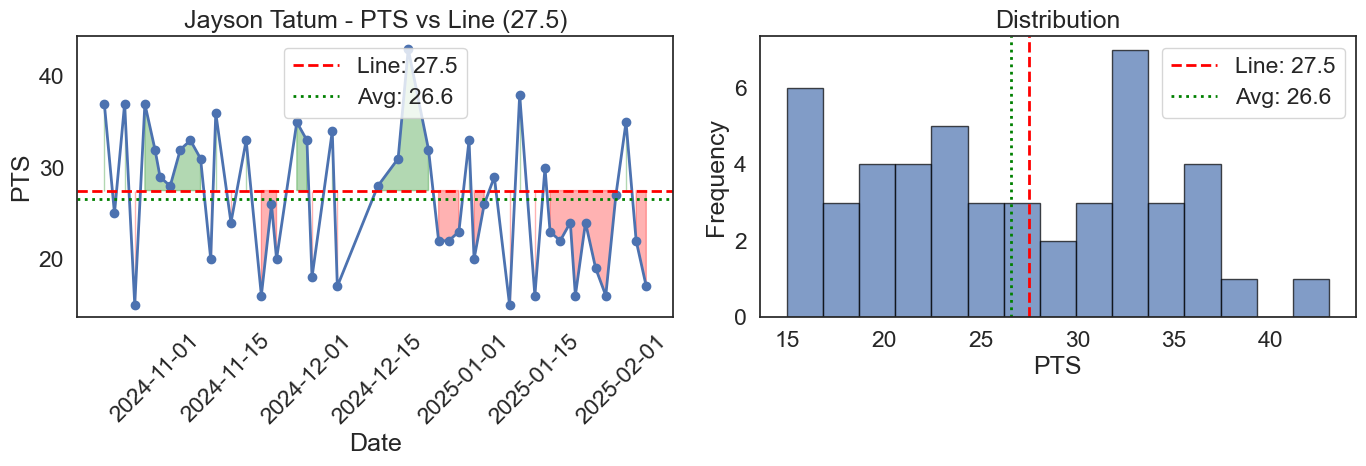


Jayson Tatum PTS Line: 27.5
OVER: 46.9% (23/49 games)
UNDER: 53.1% (26/49 games)


({'player': 'Jayson Tatum',
  'stat': 'PTS',
  'line': 27.5,
  'games_analyzed': 49,
  'average': np.float64(26.551020408163264),
  'median': np.float64(26.0),
  'std_dev': np.float64(7.393863515583368),
  'min': np.int64(15),
  'max': np.int64(43),
  'over_hits': np.int64(23),
  'under_hits': np.int64(26),
  'pushes': np.int64(0),
  'over_rate': np.float64(46.93877551020408),
  'under_rate': np.float64(53.06122448979592),
  'last_5_avg': np.float64(23.4),
  'last_10_avg': np.float64(22.2),
  'avg_minutes': np.float64(36.3165306122449)},
 {'hit_rate': {'weight': 0.4,
   'score': 0,
   'detail': '46.9% over / 53.1% under'},
  'sample_size': {'weight': 0.1, 'score': 1.0, 'detail': '49 games'},
  'recent_form': {'weight': 0.25,
   'score': 1,
   'detail': 'L5: 23.4, Trend: DOWN, Streak: 2 UNDER'},
  'opponent_defense': {'weight': 0.15,
   'score': 0.5,
   'detail': 'No opponent specified'},
  'minutes_comparison': {'weight': 0.1,
   'score': np.float64(0.1777777777777778),
   'detail': 'R

In [30]:
# Run detailed report for a specific pick
# Modify the parameters below:

PLAYER = "Jayson Tatum"
STAT = "PTS" 
LINE = 27.5
OPPONENT = None  # e.g., "MIA" or None

full_report(PLAYER, STAT, LINE, OPPONENT)

## Find Best Available Picks

In [31]:
# Find the most reliable picks across different stat categories
# Adjust min_hit_rate to be more/less selective (65-80 recommended)

MIN_HIT_RATE = 70  # Minimum hit rate percentage
MIN_GAMES = 20      # Minimum games played

print("Finding best picks with {}%+ hit rate...\n".format(MIN_HIT_RATE))

# Check multiple stat categories
for stat in ['PTS', 'TRB', 'AST', '3P', 'PTS+REB+AST']:
    best = find_best_picks(stat, min_games=MIN_GAMES, min_hit_rate=MIN_HIT_RATE)
    if len(best) > 0:
        print(f"\n=== TOP {stat} PICKS ===")
        display(best.head(10))

Finding best picks with 70%+ hit rate...


=== TOP PTS PICKS ===


,Player,Stat,Line,Direction,Hit Rate,L5 Rate,Trend,Avg,Games,Hot
35,Cory Joseph,PTS,3.5,UNDER,86.7%,100%,UP,1.9,30,
56,Zeke Nnaji,PTS,3.5,UNDER,83.9%,40%,UP,1.9,31,
68,Colby Jones,PTS,2.5,UNDER,83.3%,100%,UP,1.1,24,
6,Tyler Kolek,PTS,3.5,UNDER,82.1%,100%,DOWN,1.9,28,YES
20,Adem Bona,PTS,4.5,UNDER,80.6%,80%,UP,3.0,36,
39,Antonio Reeves,PTS,6.0,UNDER,80.0%,80%,DOWN,4.3,20,YES
19,Duop Reath,PTS,4.0,UNDER,80.0%,80%,UP,2.3,25,
38,Antonio Reeves,PTS,5.0,UNDER,80.0%,80%,DOWN,4.3,20,YES
88,Derrick Jones Jr.,PTS,12.5,UNDER,80.0%,80%,UP,11.2,20,
4,Xavier Tillman,PTS,2.5,UNDER,80.0%,80%,DOWN,1.1,20,YES



=== TOP TRB PICKS ===


,Player,Stat,Line,Direction,Hit Rate,L5 Rate,Trend,Avg,Games,Hot
283,Cory Joseph,TRB,2.5,UNDER,96.7%,100%,UP,0.8,30,
387,Doug McDermott,TRB,2.0,UNDER,93.5%,100%,DOWN,0.5,31,YES
233,Kentavious Caldwell-Pope,TRB,0.5,OVER,92.0%,100%,DOWN,2.0,50,
216,Duop Reath,TRB,2.5,UNDER,92.0%,100%,UP,0.9,25,
268,Caleb Houstan,TRB,2.5,UNDER,91.7%,80%,UP,1.0,36,
133,Jamal Shead,TRB,2.5,UNDER,91.3%,60%,UP,1.2,46,
264,Jeff Dowtin,TRB,2.5,UNDER,91.3%,80%,UP,1.2,23,
85,Jay Huff,TRB,0.5,OVER,90.9%,60%,DOWN,2.2,44,
408,Johnny Furphy,TRB,2.5,UNDER,90.6%,100%,DOWN,1.0,32,YES
444,Josh Minott,TRB,2.5,UNDER,90.3%,100%,DOWN,1.1,31,YES



=== TOP AST PICKS ===


,Player,Stat,Line,Direction,Hit Rate,L5 Rate,Trend,Avg,Games,Hot
214,Noah Clowney,AST,2.5,UNDER,97.3%,100%,UP,0.8,37,
339,Adem Bona,AST,2.0,UNDER,97.2%,100%,UP,0.3,36,
531,Anthony Gill,AST,1.5,UNDER,97.2%,100%,DOWN,0.2,36,YES
556,Johnny Davis,AST,2.0,UNDER,97.1%,100%,UP,0.3,34,
300,Tari Eason,AST,2.5,UNDER,97.1%,100%,DOWN,1.1,34,YES
348,Jonathan Kuminga,AST,0.5,OVER,96.9%,100%,UP,2.2,32,YES
224,Gary Trent,AST,2.5,UNDER,96.6%,100%,FLAT,0.9,29,
148,Derrick Jones,AST,2.5,UNDER,96.6%,100%,DOWN,0.9,29,YES
396,MarJon Beauchamp,AST,2.0,UNDER,96.3%,80%,UP,0.3,27,
291,Ron Holland,AST,2.5,UNDER,96.2%,100%,UP,0.8,52,



=== TOP 3P PICKS ===


,Player,Stat,Line,Direction,Hit Rate,L5 Rate,Trend,Avg,Games,Hot
614,Jonas Valančiūnas,3P,1.5,UNDER,98.0%,100%,UP,0.1,50,
166,T.J. McConnell,3P,1.5,UNDER,98.0%,100%,UP,0.2,49,
550,Brandon Clarke,3P,0.5,UNDER,97.9%,100%,DOWN,0.0,47,YES
202,Javonte Green,3P,2.5,UNDER,97.8%,100%,UP,0.8,46,
350,Nic Claxton,3P,0.5,UNDER,97.8%,100%,DOWN,0.0,45,YES
104,Giannis Antetokounmpo,3P,1.5,UNDER,97.6%,80%,FLAT,0.1,42,
809,RJ Barrett,3P,0.5,OVER,97.6%,100%,DOWN,1.8,41,
111,Walker Kessler,3P,1.5,UNDER,97.5%,100%,DOWN,0.1,40,YES
110,Walker Kessler,3P,0.5,UNDER,97.5%,100%,DOWN,0.1,40,YES
248,Daniel Theis,3P,1.5,UNDER,97.4%,100%,DOWN,0.2,38,YES



=== TOP PTS+REB+AST PICKS ===


,Player,Stat,Line,Direction,Hit Rate,L5 Rate,Trend,Avg,Games,Hot
40,Luka Garza,PTS+REB+AST,6.5,UNDER,85.0%,80%,DOWN,4.8,20,YES
13,Antonio Reeves,PTS+REB+AST,7.5,UNDER,80.0%,60%,DOWN,5.8,20,YES
24,Johnny Davis,PTS+REB+AST,5.5,UNDER,79.4%,100%,DOWN,3.8,34,YES
42,Kristaps Porziņģis,PTS+REB+AST,26.5,OVER,77.8%,80%,UP,28.2,27,YES
21,Alex Len,PTS+REB+AST,5.5,UNDER,77.8%,100%,DOWN,4.1,36,YES
45,Micah Potter,PTS+REB+AST,10.0,UNDER,77.3%,80%,DOWN,8.3,22,YES
20,Jaden Springer,PTS+REB+AST,4.5,UNDER,76.9%,80%,UP,3.0,26,
6,Duop Reath,PTS+REB+AST,5.0,UNDER,76.0%,100%,UP,3.4,25,
17,Tre Jones,PTS+REB+AST,11.5,UNDER,75.0%,60%,UP,10.2,28,
26,Zeke Nnaji,PTS+REB+AST,4.5,UNDER,74.2%,20%,UP,3.0,31,
